In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from us_state_abbrev import us_state_abbrev #thanks to Github: rogerallen

Using TensorFlow backend.


# Input data:

In [2]:
# Split words using delimiter

def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]

# Read csv of Education distribution
# Remove all the entries that don't have "County"

df = pd.read_csv('Education_data_compiled.csv')
df = df[df['Area name'].str.contains('County')]
df['Area name'] = df['Area name'].map(lambda x: f(x,' ')[0])
df = df.sort_values(by=['State','Area name'],ignore_index=True)
display(df)

,State,Area name,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18"
0,AL,Autauga,11.3,32.6,28.4,27.7
1,AL,Baldwin,9.7,27.6,31.3,31.3
2,AL,Barbour,27.0,35.7,25.1,12.2
3,AL,Bibb,16.8,47.3,24.4,11.5
4,AL,Blount,19.8,34.0,33.5,12.6
...,...,...,...,...,...,...
3002,WY,Sweetwater,9.0,33.3,35.7,22.0
3003,WY,Teton,5.6,13.2,23.8,57.4
3004,WY,Uinta,7.2,40.1,37.2,15.4
3005,WY,Washakie,10.4,30.3,37.7,21.5


In [3]:
# Add columns of Unemployment and Median HH Income
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'],ignore_index=True)

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x,' ')[0])
new_df['Median_Household_Income_2018'] = new_df['Median_Household_Income_2018'].map(lambda x: (f(x)[0]+f(x)[1]))

new_df = new_df.sort_values(by=['State','Area name'],ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019", 
                       "Median_Household_Income_2018": "Median Household Income 2018"})
df["Median Household Income 2018"] = df["Median Household Income 2018"].astype(float)
display(df)

,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018
0,AL,Autauga,11.3,32.6,28.4,27.7,2.7,5938.0
1,AL,Baldwin,9.7,27.6,31.3,31.3,2.7,5788.0
2,AL,Barbour,27.0,35.7,25.1,12.2,3.8,3482.0
3,AL,Bibb,16.8,47.3,24.4,11.5,3.1,4664.0
4,AL,Blount,19.8,34.0,33.5,12.6,2.7,5012.0
...,...,...,...,...,...,...,...,...
3104,WY,Sweetwater,9.0,33.3,35.7,22.0,3.9,7315.0
3105,WY,Teton,5.6,13.2,23.8,57.4,2.7,9987.0
3106,WY,Uinta,7.2,40.1,37.2,15.4,3.9,6301.0
3107,WY,Washakie,10.4,30.3,37.7,21.5,3.9,5590.0


# Normalize stationary data

In [4]:
df_norm = df.copy()
df["Median Household Income 2018"]=round(df_norm["Median Household Income 2018"]/np.max(df_norm["Median Household Income 2018"])*100,2)

# Add data of Covid cases

In [5]:
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
COVID_counties_df['State'] = COVID_counties_df['state'].map(us_state_abbrev)
del COVID_counties_df['fips']
del COVID_counties_df['state']
COVID_counties_df = COVID_counties_df.sort_values(by=['State','county'],ignore_index=True)
COVID_counties_df = COVID_counties_df.rename(columns={"county": "County"})
cols = list(COVID_counties_df.columns.values)
cols = [cols[0]] + cols[-1:] + cols[1:-1]
COVID_counties_df = COVID_counties_df[cols]
display(COVID_counties_df)
display(df)


,date,State,County,cases,deaths
0,6/9/2020,AK,Aleutians East Borough,1,0
1,6/10/2020,AK,Aleutians East Borough,1,0
2,6/11/2020,AK,Aleutians East Borough,1,0
3,6/12/2020,AK,Aleutians East Borough,1,0
4,6/13/2020,AK,Aleutians East Borough,1,0
...,...,...,...,...,...
573333,9/22/2020,WY,Weston,26,0
573334,9/23/2020,WY,Weston,25,0
573335,9/24/2020,WY,Weston,27,0
573336,9/25/2020,WY,Weston,35,0


,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018
0,AL,Autauga,11.3,32.6,28.4,27.7,2.7,42.17
1,AL,Baldwin,9.7,27.6,31.3,31.3,2.7,41.10
2,AL,Barbour,27.0,35.7,25.1,12.2,3.8,24.73
3,AL,Bibb,16.8,47.3,24.4,11.5,3.1,33.12
4,AL,Blount,19.8,34.0,33.5,12.6,2.7,35.59
...,...,...,...,...,...,...,...,...
3104,WY,Sweetwater,9.0,33.3,35.7,22.0,3.9,51.95
3105,WY,Teton,5.6,13.2,23.8,57.4,2.7,70.92
3106,WY,Uinta,7.2,40.1,37.2,15.4,3.9,44.75
3107,WY,Washakie,10.4,30.3,37.7,21.5,3.9,39.70


In [6]:
# Testing with Baltimore county
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['County']=='Baltimore']
stat_data_baltimore_df=df.loc[df['County'].str.contains('Baltimore')&df['State'].str.contains('MD')]

# Extracting number:
stat_data_baltimore = stat_data_baltimore_df.drop(columns=['County', 'State']).values.tolist()
stat_data_baltimore = np.array(stat_data_baltimore[0])

# Prediction

In [7]:
# Run the prediction

# split a univariate sequence into samples
def split_sequence(sequence, n_steps, features_data): #features = other data of the county 
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        seq_x = np.append(seq_x,features_data)
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Perform prediction 
def single_pred(x_input, n_steps, features_length, n_features):
    x_input = x_input.reshape((1, n_steps+features_length, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def make_prediction(cases_train, n_steps, features_data):
    features_length = len(features_data)
    num_pred = len(cases)-n_steps
    yhat_array = np.zeros(num_pred)
    for i in range(num_pred):
        if i < len(cases_train)-n_steps:
            x_input = cases_train[i:i+n_steps]
            x_input = np.append(x_input,features_data)
            yhat = single_pred(x_input, n_steps, features_length, n_features)
            yhat_array[i] = yhat
        else:
            x_input = np.append(x_input[1:n_steps],yhat) # create feature from previous prediction
            x_input = np.append(x_input,features_data) # insert stationary feature
            yhat = single_pred(x_input, n_steps, features_length, n_features)
            yhat_array[i] = yhat
    return yhat_array


In [8]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
test_train_split = 0.7
cases_train = cases[0:int(len(cases)*test_train_split)]
cases_test = cases[int(len(cases)*test_train_split):]

features_data = stat_data_baltimore
features_length = len(features_data)

In [9]:
# Perform prediction:

# choose a number of time steps (how many days to use for prediction)
n_steps = 3

# split into samples
X, y = split_sequence(cases_train, n_steps,features_data)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore)
#print(yhat_array)


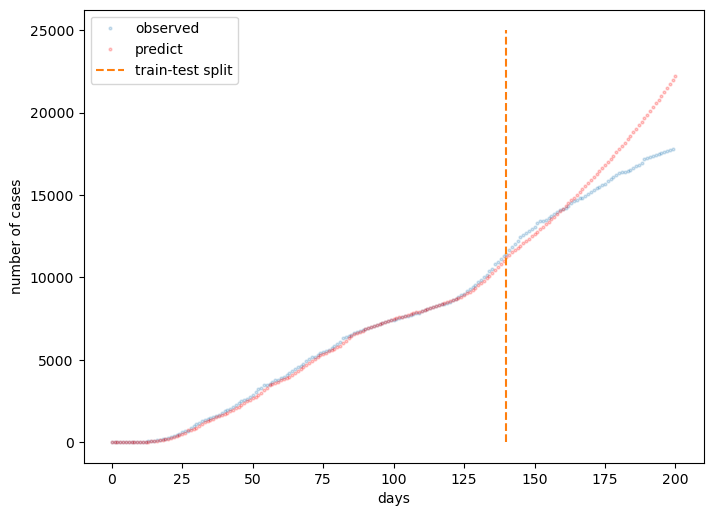

In [10]:
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.legend()

# Testing performance with different steps

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

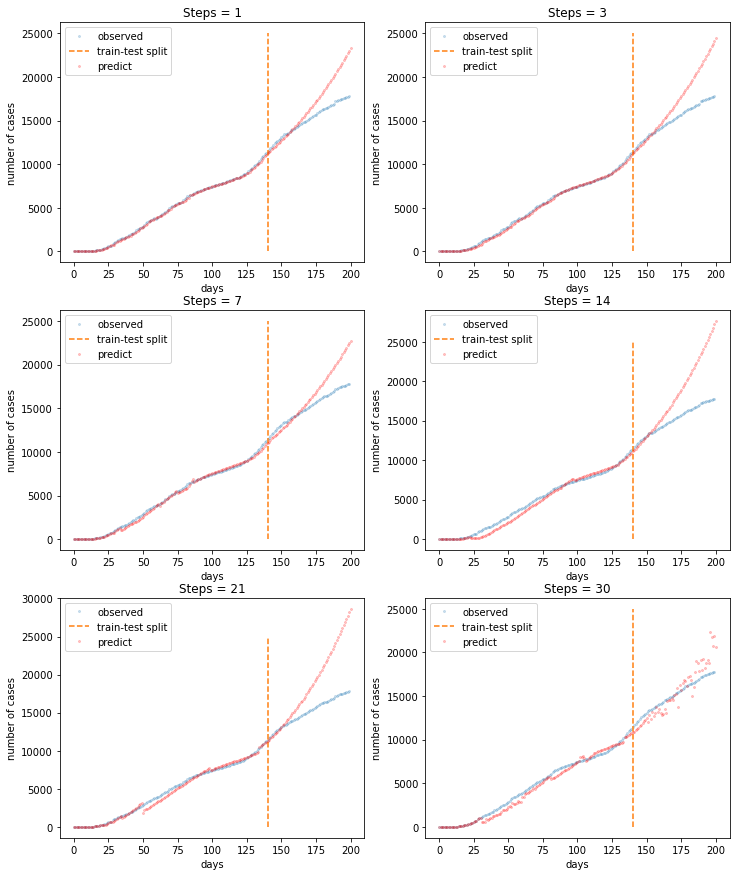

In [12]:
steps_list = [1,3,7,14,21,30]

fig,ax = plt.subplots(3,2,figsize=(12,15))

# By the way, take a look at these numpy commands: reshape and where
rowcollist = np.arange(1,7)

# 4,3 means 4 rows, 3 columns
rowcollist = rowcollist.reshape(3,2)

for i in range(0,len(rowcollist)):
    row,col = np.where(rowcollist == i+1)
    #print(row[0], col[0])

# Perform prediction:
for i in range(len(steps_list)):
    # choose a number of time steps (how many days to use for prediction)
    n_steps = steps_list[i]

    # split into samples
    X, y = split_sequence(cases_train, n_steps,features_data)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore)
    #print(yhat_array)

    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(cases,'o',markersize=2,alpha=0.2,label='observed')
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
    ax[row[0]][col[0]].plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
    ax[row[0]][col[0]].set_xlabel('days')
    ax[row[0]][col[0]].set_ylabel('number of cases')
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i]))
fig.show

# Run the model with all counties

In [84]:
# Function to apply model to all available counties

def predict_all(ts_df,stat_df,n_steps,test_train_split):
    prediction_df = pd.DataFrame(columns = ['State','County','Predicted cases'])
    list_counties = list(stat_df[['State', 'County']].apply(tuple, axis=1))
    it = iter(range(len(list_counties)))
    for i in it:
        # time-series data of the county
        county_ts = ts_df.loc[(ts_df['State']==list_counties[i][0])&(ts_df['County']==list_counties[i][1])] 
        # stationary data of the county
        county_stat_df = stat_df.loc[(stat_df['State']==list_counties[i][0])&(stat_df['County']==list_counties[i][1])]
        county_stat = county_stat_df.drop(columns=['County', 'State']).values.tolist()
        county_stat = np.array(county_stat[0])
        
        # Data:
        cases = np.array(county_ts['cases'])
        # Split data to train the model: 70:30
        cases_train = cases[0:int(len(cases)*test_train_split)]
        cases_test = cases[int(len(cases)*test_train_split):]

        features_data = county_stat
        features_length = len(features_data)
        
        # Perform prediction:

        # choose a number of time steps (how many days to use for prediction)
        n_steps = 1

        # split into samples
        X, y = split_sequence(cases_train, n_steps,features_data)
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        if len(X)<=1:
            next(it)
        else:
            X = X.reshape((X.shape[0], X.shape[1], n_features))

            # define model
            model = Sequential()
            model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')

            # fit model
            model.fit(X, y, epochs=200, verbose=0)
    
            yhat_array = make_prediction(cases_train, n_steps, county_stat)
        
            county_pred = pd.DataFrame([[list_counties[i][0],list_counties[i][1],
                                     yhat_array[int(len(cases)*test_train_split):int(len(cases)*test_train_split)+7]]], 
                                     columns=['State','County','Predicted cases'])
            prediction_df = prediction_df.append(county_pred)
    
    return prediction_df


In [ ]:
prediction_df = predict_all(COVID_counties_df,df,3,0.7)
display(prediction_df)

In [59]:
display(prediction_df)

,State,County,Predicted cases
0,AL,Autauga,"[885.3109130859375, 876.531982421875, 869.6055..."
0,AL,Baldwin,"[1817.051025390625, 1596.7198486328125, 1338.0..."
0,AL,Barbour,"[664.3538208007812, 681.6221923828125, 698.307..."
0,AL,Bibb,"[372.45733642578125, 373.99139404296875, 375.5..."
0,AL,Blount,"[810.1849365234375, 824.20703125, 838.00018310..."
0,AL,Bullock,"[473.8173828125, 486.9178161621094, 500.459655..."
0,AL,Butler,"[674.1717529296875, 669.6400146484375, 667.054..."
0,AL,Calhoun,"[944.853271484375, 940.2866821289062, 935.3953..."
0,AL,Chambers,"[815.9832763671875, 813.153564453125, 810.9348..."
0,AL,Cherokee,"[309.0506896972656, 323.296630859375, 336.6880..."


In [79]:
df.loc[df['County']=='Monroe']

,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018
49,AL,Monroe,16.3,46.1,23.5,14.1,4.9,28.09
114,AR,Monroe,22.9,43.0,23.6,10.5,4.3,22.88
387,FL,Monroe,8.7,27.3,30.7,33.3,2.1,48.25
514,GA,Monroe,15.0,33.9,24.8,26.3,3.2,42.34
643,IA,Monroe,12.0,40.7,30.8,16.6,3.1,40.06
784,IL,Monroe,4.0,29.2,34.3,32.5,3.1,63.07
872,IN,Monroe,7.8,21.9,24.7,45.6,3.3,34.68
1102,KY,Monroe,25.5,40.2,21.4,12.9,3.9,25.54
1247,MI,Monroe,8.8,36.1,36.0,19.1,3.9,44.18
1432,MO,Monroe,10.5,48.3,28.3,12.8,4.2,32.78
